## Shors Algorithm

In [6]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import QFT
import qiskit.quantum_info as qinf
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService
from qiskit.visualization import *
from PIL import Image
from qiskit.result import counts
import matplotlib.pyplot as plt
import math

In [7]:
# Constants
N = 15  # Number to factor
A = 7   # Chosen coprime to N (A must be coprime to N)

# Step 1: Prepare the quantum circuit
qc = QuantumCircuit(8, 4)

# Apply Hadamard gates to the first 4 qubits (superposition)
for i in range(4):
    qc.h(i)

# Initialize the last qubit to |1>
qc.x(7)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=8, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(8, 'q'), 0), Qubit(QuantumRegister(8, 'q'), 1), Qubit(QuantumRegister(8, 'q'), 2), Qubit(QuantumRegister(8, 'q'), 3), Qubit(QuantumRegister(8, 'q'), 4), Qubit(QuantumRegister(8, 'q'), 5), Qubit(QuantumRegister(8, 'q'), 6), Qubit(QuantumRegister(8, 'q'), 7)), clbits=())

In [8]:
# Step 2 and 3: Controlled modular exponentiation
def c_amod15(a, x):
    if a not in [2, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2, 7, 8, 11, or 13")
    U = QuantumCircuit(4)
    for iteration in range(x):
        if a in [2, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [7, 8]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a == 11:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U

def modular_exponentiation(circuit, n, m, a):
    for x in range(n):
        exponent = 2**x
        circuit.append(c_amod15(a, exponent), [x] + list(range(n, n + m)))

# Apply the controlled modular exponentiation
gate_label = "%i^x mod %i" % (A, N)
modular_exponentiation(qc, 4, 4, A)
qc.barrier()

# Step 4: Quantum Fourier Transform (QFT) on the first register
def inverse_qft(circuit, measurement_qubits):
    circuit.append(QFT(len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)

inverse_qft(qc, range(4))

# Step 5: Measure the first register
qc.measure(range(4), range(4))


In [9]:
# Decompose the circuit to standard gates
qc = qc.decompose()

# Draw the circuit
print("Circuit Diagram:")
print(qc.draw())

Circuit Diagram:
      ┌─────────┐  ░                                                        »
q_0: ─┤ U2(0,π) ├──░───■────■────■────■────■────■────■────■────■────■────■──»
      ├─────────┤  ░   │    │    │    │    │    │    │    │    │    │    │  »
q_1: ─┤ U2(0,π) ├──░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      ├─────────┤  ░   │    │    │    │    │    │    │    │    │    │    │  »
q_2: ─┤ U2(0,π) ├──░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      ├─────────┤  ░   │    │    │    │    │    │    │    │    │    │    │  »
q_3: ─┤ U2(0,π) ├──░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
      └─────────┘  ░   │    │    │    │    │    │    │  ┌─┴─┐  │  ┌─┴─┐  │  »
q_4: ──────────────░───┼────┼────┼────┼────┼────┼────■──┤ X ├──■──┤ X ├──┼──»
                   ░   │    │    │    │  ┌─┴─┐  │  ┌─┴─┐└─┬─┘┌─┴─┐└───┘┌─┴─┐»
q_5: ──────────────░───┼────┼────┼────■──┤ X ├──■──┤ X ├──■──┤ X ├─────┤ X ├»
                   ░   │  ┌─┴─┐  │  ┌─┴─┐└─┬─┘┌


Measurement results:
State 0000: 247
State 0001: 225
State 0010: 97
State 0011: 29
State 0101: 10
State 0110: 22
State 0111: 4
State 1001: 10
State 1010: 21
State 1011: 13
State 1101: 27
State 1110: 98
State 1111: 221


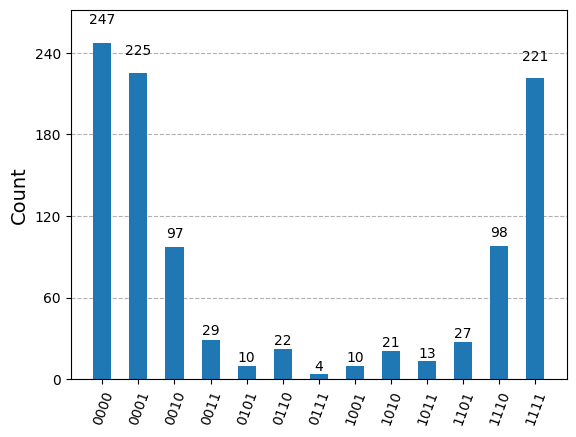

In [10]:

# Simulate the circuit
simulator = AerSimulator()

# Transpile the circuit for the simulator
qc_t_aer = transpile(qc, backend=simulator, basis_gates=['u1', 'u2', 'u3', 'cx', 'id'])

# Run the simulation
no_shots = 1024
result = simulator.run(qc_t_aer, shots=no_shots).result()

# Get and display the counts
counts = result.get_counts()
print("\nMeasurement results:")
for state, count in sorted(counts.items()):
    print(f"State {state}: {count}")

# Plot the histogram
plot_histogram(counts)


# Analyze the results to deduce the period
# Additional processing for interpreting results can be added here.

In [11]:
for i in counts:
    # Reverse the measured bitstring and interpret as a decimal integer
    measured_value = int(i[::-1], 2)
    
    # Ensure the measured value is even
    if measured_value % 2 != 0:
        print(f"Measured value {measured_value} is not even. Skipping...")
        continue
    
    # Calculate a^(r/2) mod N
    half_period = measured_value // 2
    x = pow(A, half_period, N)
    
    # Check for trivial factors
    if (x + 1) % N == 0:
        print(f"Trivial factor encountered for measured value {measured_value}. Skipping...")
        continue
    
    # Calculate potential factors
    factors = (math.gcd(x + 1, N), math.gcd(x - 1, N))
    
    # Ensure non-trivial factors
    if factors[0] > 1 and factors[1] > 1:
        print(f"Factors of {N} found with {measured_value}: {factors}")
    else:
        print(f"No non-trivial factors found for measured value {measured_value}.")

No non-trivial factors found for measured value 8.
Factors of 15 found with 4: (5, 3)
No non-trivial factors found for measured value 6.
Measured value 15 is not even. Skipping...
No non-trivial factors found for measured value 0.
Measured value 11 is not even. Skipping...
No non-trivial factors found for measured value 10.
Measured value 7 is not even. Skipping...
Measured value 9 is not even. Skipping...
Measured value 5 is not even. Skipping...
Factors of 15 found with 12: (5, 3)
No non-trivial factors found for measured value 14.
Measured value 13 is not even. Skipping...


In [9]:
# Using IBM 
back_lb = QiskitRuntimeService().least_busy(operational=True, min_num_qubits=5)
sampler_lb = SamplerV2(back_lb)

In [10]:
qc_lb=transpile(qc,backend=back_lb)
## qc_lb.draw(output='mpl',idle_wires=False) to large
lb_job=sampler_lb.run([(qc_lb,None,no_shots)])

In [16]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='6c43a9d21777a56fa00b9cff43b1304d4243f7a041c9ad8fc7d2c05a1a6695e8e37fb9fd1d49ac4d49efb8ec395abab21c32d617bf276ea6416bffa0aa07b021'
)
job = service.job('cxfrwvv3ej4g008g2j60')
job_result = job.result()
print(qc.cregs)

[ClassicalRegister(4, 'c')]



Measurement results:
State 0000: 99
State 0001: 117
State 0010: 56
State 0011: 64
State 0100: 25
State 0101: 53
State 0110: 36
State 0111: 38
State 1000: 120
State 1001: 133
State 1010: 43
State 1011: 84
State 1100: 25
State 1101: 50
State 1110: 46
State 1111: 35


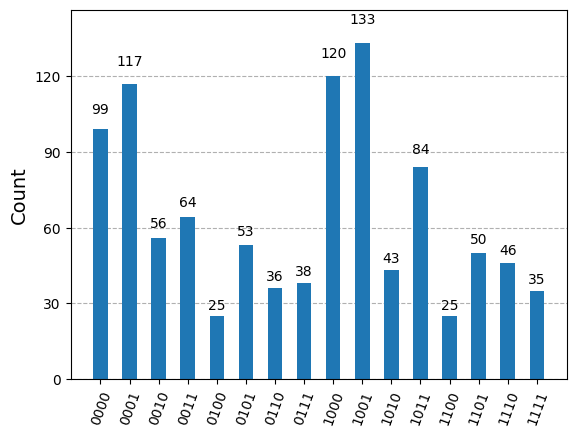

In [18]:
# Get and display the counts
IBMcounts = job_result[0].data.c.get_counts()
print("\nMeasurement results:")
for state, count in sorted(IBMcounts.items()):
    print(f"State {state}: {count}")

# Plot the histogram
plot_histogram(IBMcounts)

In [21]:
for i in IBMcounts:
    # Reverse the measured bitstring and interpret as a decimal integer
    measured_value = int(i[::-1], 2)
    
    # Ensure the measured value is even
    if measured_value % 2 != 0:
        print(f"Measured value {measured_value} is not even. Skipping...")
        continue
    
    # Calculate a^(r/2) mod N
    half_period = measured_value // 2
    x = pow(A, half_period, N)
    
    # Check for trivial factors
    if (x + 1) % N == 0:
        print(f"Trivial factor encountered for measured value {measured_value}. Skipping...")
        continue
    
    # Calculate potential factors
    factors = (math.gcd(x + 1, N), math.gcd(x - 1, N))
    
    # Ensure non-trivial factors
    if factors[0] > 1 and factors[1] > 1:
        print(f"Factors of {N} found with {measured_value}: {factors}")
    else:
        print(f"No non-trivial factors found for measured value {measured_value}.")

Factors of 15 found with 12: (5, 3)
Measured value 1 is not even. Skipping...
No non-trivial factors found for measured value 8.
No non-trivial factors found for measured value 10.
No non-trivial factors found for measured value 14.
Measured value 9 is not even. Skipping...
No non-trivial factors found for measured value 2.
Factors of 15 found with 4: (5, 3)
Measured value 15 is not even. Skipping...
No non-trivial factors found for measured value 0.
Measured value 11 is not even. Skipping...
Measured value 5 is not even. Skipping...
Measured value 13 is not even. Skipping...
No non-trivial factors found for measured value 6.
Measured value 7 is not even. Skipping...
Measured value 3 is not even. Skipping...
